In [2]:
import numpy as np
from numpy import zeros,ones
from numpy.random import randn,randint
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.initializers import RandomNormal
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Conv2D,Dense, Conv2DTranspose, BatchNormalization,  Dropout, LeakyReLU, Flatten,Input,Concatenate

In [3]:
colorPath = "../input/landscape-image-colorization/landscape Images/color/"
grayPath = "../input/landscape-image-colorization/landscape Images/gray/"

In [4]:
import os

colorImgPath = []
grayImgPath = []

for imgPath in os.listdir(colorPath) :
    colorImgPath.append(os.path.join(colorPath, imgPath))
    
for imgPath in os.listdir(grayPath) :
    grayImgPath.append(os.path.join(grayPath, imgPath))

In [5]:
colorImgPath.sort()
grayImgPath.sort()

In [6]:
from PIL import Image
from tensorflow.keras.utils import img_to_array

X = []
Y = []

for i in range(5000) :
    
    img1 = cv2.cvtColor(cv2.imread(colorImgPath[i]), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(grayImgPath[i]), cv2.COLOR_BGR2GRAY)
    
    Y.append(img_to_array(Image.fromarray(cv2.resize(img1,(128,128)))))
    X.append(img_to_array(Image.fromarray(cv2.resize(img2,(128,128)))))

In [7]:
X=np.array(X)
Y=np.array(Y)

print(X.min())
print(X.max())
print(Y.min())
print(Y.max())

0.0
255.0
0.0
255.0


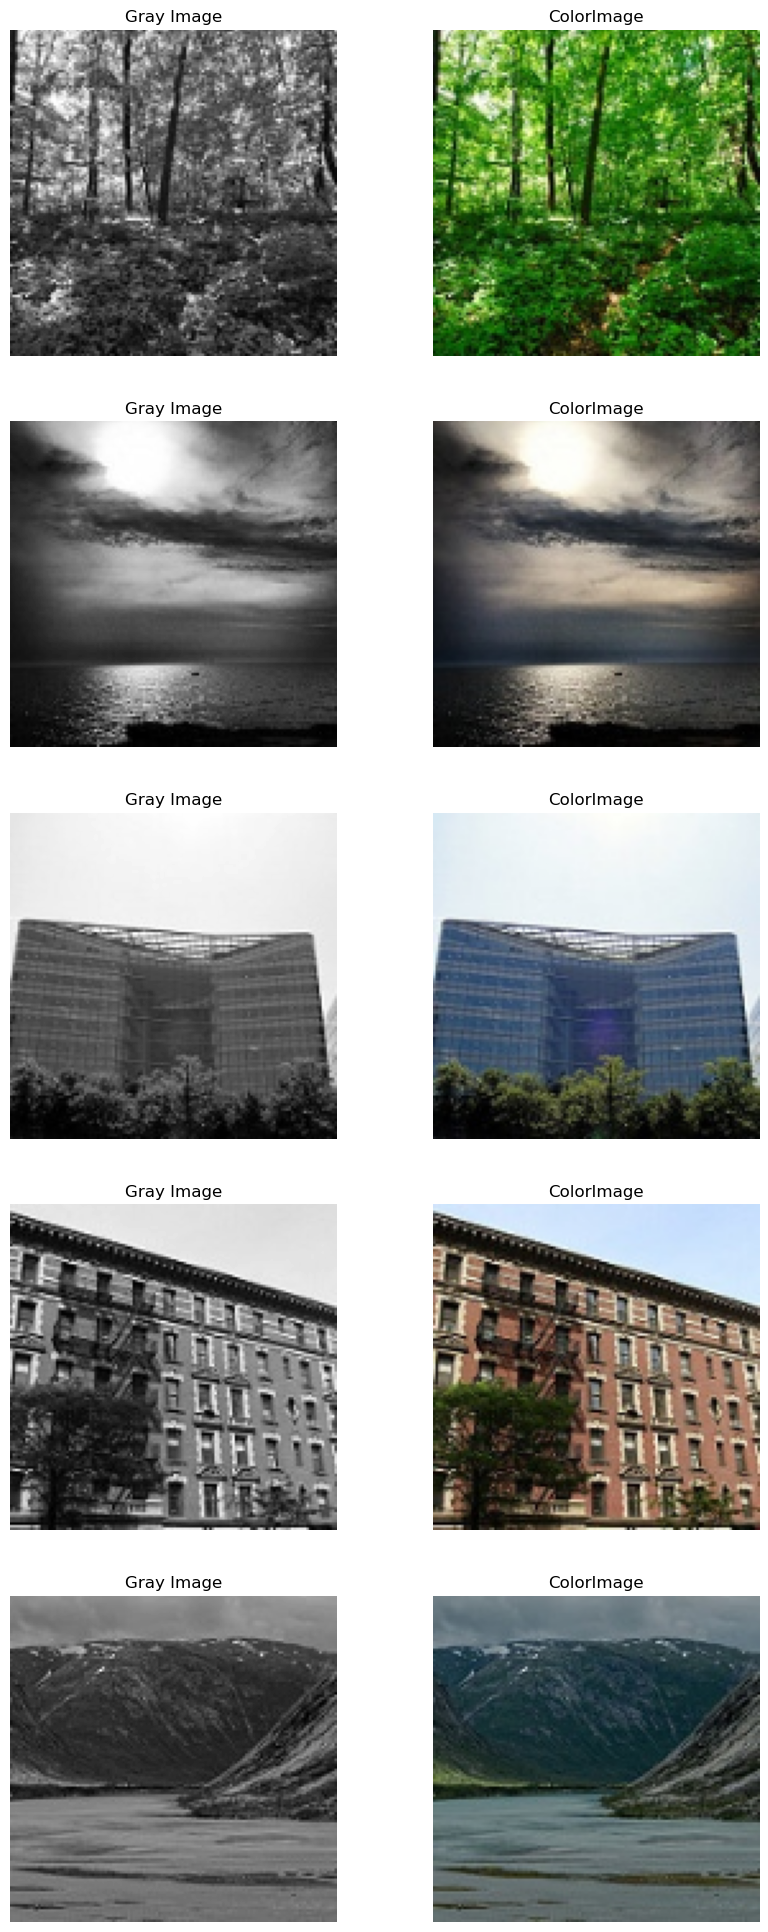

In [8]:
plt.figure(figsize = (10,50))

i = 0

while i < 10:
    
    x = np.random.randint(0,3000)
    
    plt.subplot(10, 2, i+1)
    plt.imshow(X[x]/255.0,'gray')
    plt.axis('off')
    plt.title('Gray Image')
    
    plt.subplot(10, 2, i+2)
    plt.imshow(Y[x]/ 255.0)
    plt.axis('off')
    plt.title('ColorImage')
    i += 2
plt.show()

In [9]:
X=(X/127.5)-1
Y=(Y/127.5)-1

print(X.min())
print(X.max())
print(Y.min())
print(Y.max())

-1.0
1.0
-1.0
1.0


In [10]:
trainX, testX, trainY, testY = train_test_split(X, Y,test_size=0.15)

In [11]:
print("Train dataset shape")
print(trainX.shape)
print(trainY.shape)
print("\nTest dataset shape")
print(testX.shape)
print(testY.shape)

Train dataset shape
(4250, 128, 128, 1)
(4250, 128, 128, 3)

Test dataset shape
(750, 128, 128, 1)
(750, 128, 128, 3)


In [12]:
init=RandomNormal(mean=0.0, stddev=0.02)

In [13]:
def defineDiscriminator():
    # Define input layers for grayscale image and predicted/ground truth image
    input_gray = Input(shape=(128, 128, 1,))
    input_color = Input(shape=(128, 128, 3,))
    
    # Concatenate the grayscale and color images on the channel axis
    combined_input = Concatenate()([input_gray, input_color])
    
    # Downsampling layers
    x = Conv2D(64, (2, 2), strides=2, padding='same',use_bias=False,kernel_initializer=init)(combined_input)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (2, 2), strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(256, (2, 2), strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(512, (2, 2), strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    # Flatten and add a hidden layer
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    
    # Output layer with sigmoid activation function
    output = Dense(1, activation='sigmoid')(x)

    # Define model with two inputs and one output
    model = Model(inputs=[input_gray, input_color], outputs=output)
    
    return model

In [14]:
exampleDiscriminator = defineDiscriminator()
print(exampleDiscriminator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 4)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [15]:
def defineGenerator():
    srcImage = Input(shape=(128, 128, 1,))
    
        # Downsample
    x=Conv2D(64, kernel_size=1, strides=1, padding='same',use_bias=False,kernel_initializer=init)(srcImage)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(128, kernel_size=2, strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(256, kernel_size=2, strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(512, kernel_size=2, strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    # Upsample
    x=Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=Dropout(0.5)(x)


    x=Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',use_bias=False,kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=Dropout(0.5)(x)

    # Output layer
    x=Conv2D(3, kernel_size=1, strides=1, padding='same', activation='tanh',use_bias=False,kernel_initializer=init)(x)

    model =Model(inputs=srcImage,outputs=x)

    return model

In [16]:
testGenerator = defineGenerator()
print(testGenerator.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      64        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       32768     
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                           

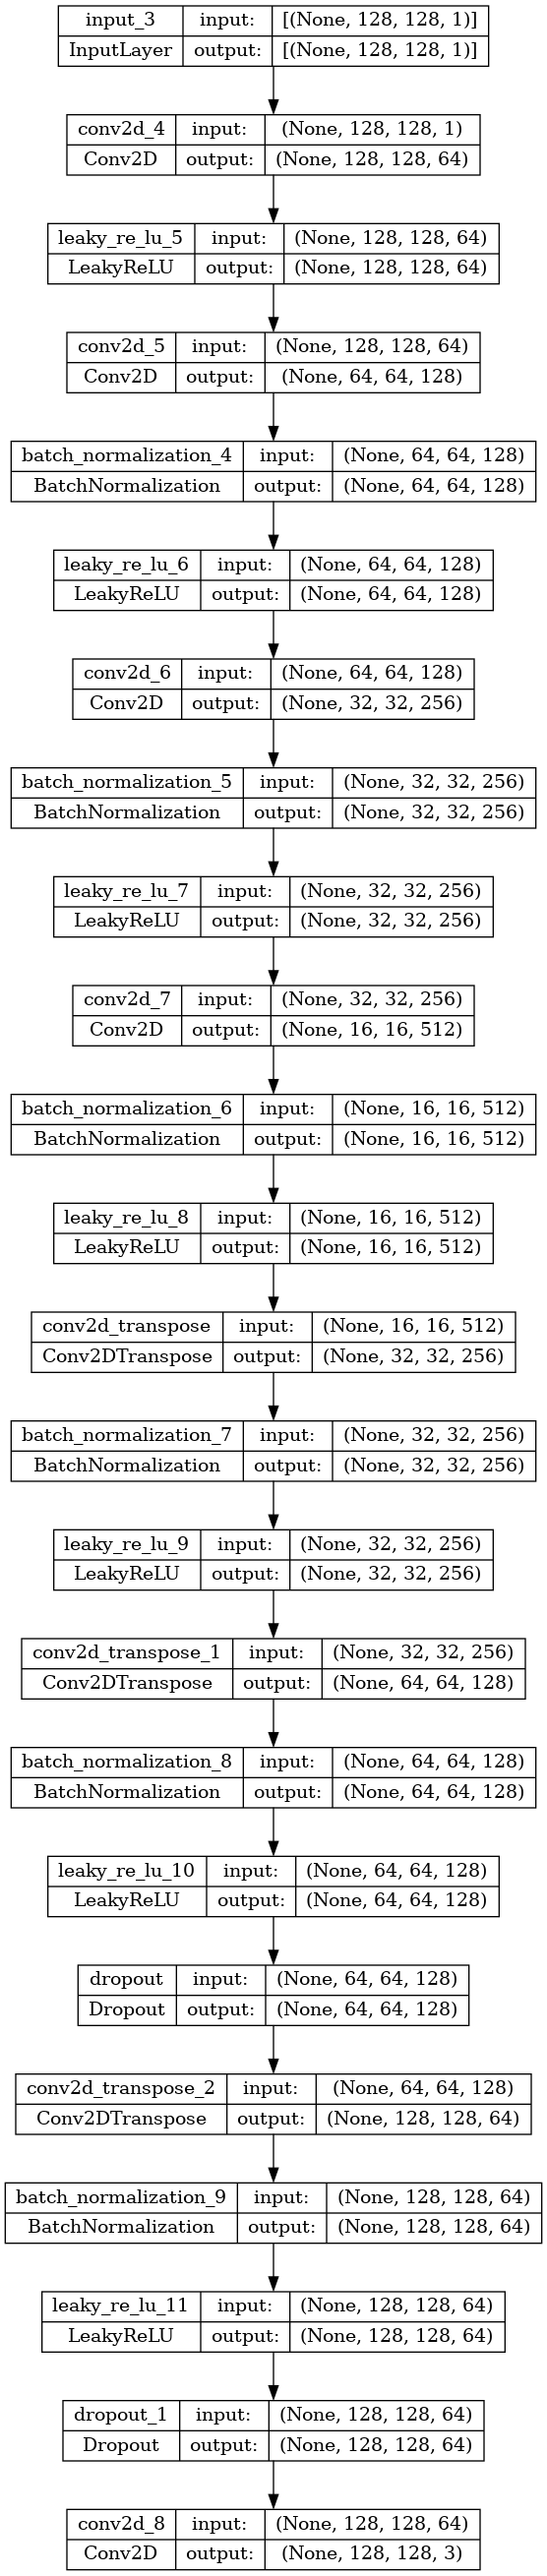

In [29]:
plot_model(testGenerator, './generatorModel.png', show_shapes = True)

In [17]:
Lambda = 100
batchSize=16
bufferSize=400
trainDataset=tf.data.Dataset.from_tensor_slices((trainX,trainY))
testDataset=tf.data.Dataset.from_tensor_slices((testX,testY))

trainDataset=trainDataset.shuffle(buffer_size=bufferSize).batch(batch_size=batchSize)
testDataset=testDataset.shuffle(buffer_size=bufferSize).batch(batch_size=batchSize)

In [18]:
generator=defineGenerator()
discriminator=defineDiscriminator()

In [19]:
binaryEntropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
genOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)
disOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)

In [21]:
def defineGenLoss(disGenOutput, tarImage, genOutput):
    adLoss=binaryEntropy(tf.ones_like(disGenOutput),disGenOutput)
    l1Loss=tf.reduce_mean(tf.abs(tf.subtract(tarImage,genOutput)))
    totalLoss=adLoss+(Lambda*l1Loss)
    return totalLoss, adLoss,l1Loss
    
def defineDisLoss(disGenOutput, disTarOutput):
    genLoss = binaryEntropy(tf.zeros_like(disGenOutput),disGenOutput)
    tarLoss = binaryEntropy(tf.ones_like(disTarOutput),disTarOutput)
    totalDisLoss = genLoss + tarLoss
    return totalDisLoss

In [22]:
def defineGAN(generator,discriminator,bwImage,tarImage):
    with tf.GradientTape(persistent=True) as g:
        genImage = generator(bwImage, training=True)

        disTarOutput = discriminator([bwImage,tarImage],training=True)
        disGenOutput = discriminator([bwImage,tarImage],training=True)

        #Losses
        genLoss = defineGenLoss(disGenOutput,tarImage,genImage)
        disLoss = defineDisLoss(disGenOutput,disTarOutput)
    genGradient=g.gradient(genLoss, generator.trainable_variables)
    disGradient=g.gradient(disLoss, discriminator.trainable_variables)
    

In [23]:
for globalBWImage, globalTarImage in trainDataset.take(1):
    pass

In [31]:
def fig (bwImage, genImage, tarImage) :
    plt.figure(figsize = (20, 20))
    
    plt.subplot(1,3,1)
    plt.imshow((bwImage[0] + 1.0) / 2.0)
    plt.title('BandW Image',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow((genImage[0] + 1.0) / 2.0)
    plt.title('GenerateImg',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow((tarImage[0] + 1.0) / 2.0)
    plt.title('Colored Img',fontsize = 20)
    plt.axis('off')
    
    plt.show()

def fit (epochs = 200) :
    
    for epoch in range(epochs) :
        
        print(f'Epoch {epoch} out of {epochs}')
        
        for n, (bwImage, tarImage) in trainDataset.enumerate() :
            if n ==  265 :
                print('#....End')
            if n%20 == 0 :
                print('#',end='')
            
            defineGAN(generator,discriminator,bwImage, tarImage)
            
        
    globalGenImage = generator(globalBWImage,training = True)
    fig(globalBWImage, globalGenImage, globalTarImage)

Epoch 0 out of 100
#

/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


##############....End
Epoch 1 out of 100
###############....End
Epoch 2 out of 100
###############....End
Epoch 3 out of 100
###############....End
Epoch 4 out of 100
###############....End
Epoch 5 out of 100
###############....End
Epoch 6 out of 100
###############....End
Epoch 7 out of 100
###############....End
Epoch 8 out of 100
###############....End
Epoch 9 out of 100
###############....End
Epoch 10 out of 100
###############....End
Epoch 11 out of 100
###############....End
Epoch 12 out of 100
###############....End
Epoch 13 out of 100
###############....End
Epoch 14 out of 100
###############....End
Epoch 15 out of 100
###############....End
Epoch 16 out of 100
###############....End
Epoch 17 out of 100
###############....End
Epoch 18 out of 100
###############....End
Epoch 19 out of 100
###############....End
Epoch 20 out of 100
###############....End
Epoch 21 out of 100
###############....End
Epoch 22 out of 100
###############....End
Epoch 23 out of 100
###############....En

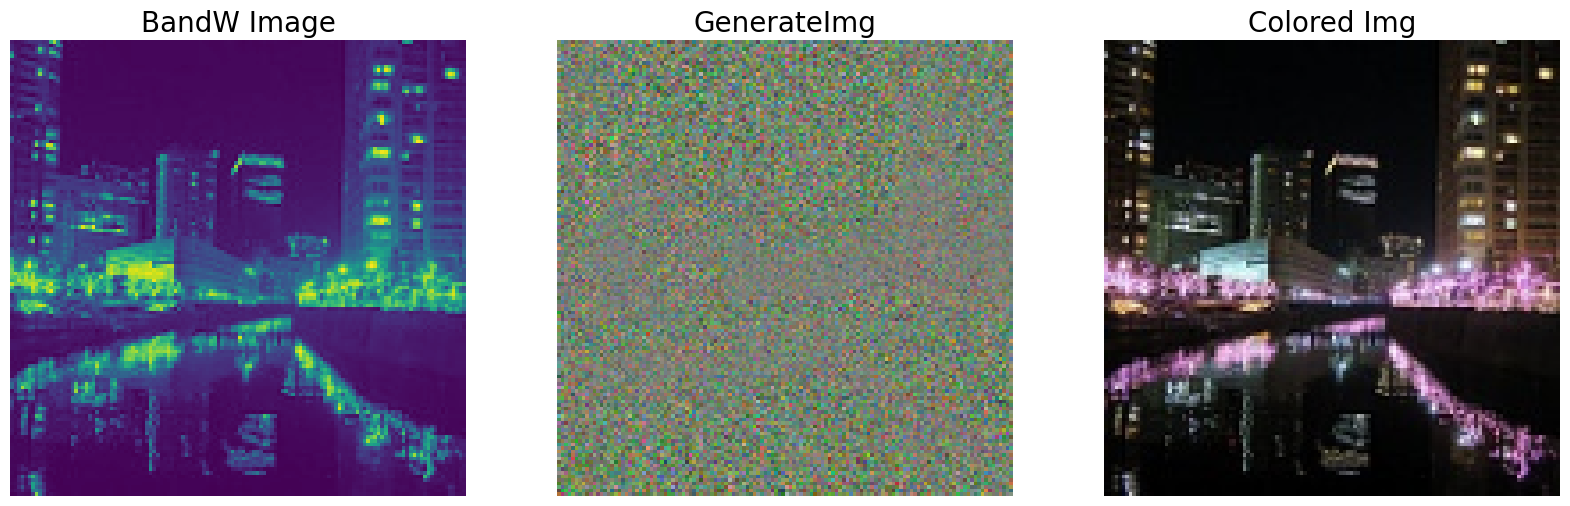

In [32]:
fit(epochs=100)